In [1]:
import pandas as pd
import numpy as np

from keras import Input
from keras.engine import Model
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Concatenate, concatenate
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:

# features is a list of strings of feature names 

def build_model(features, data_length):
    
    inputs_list = [] 
    for feature_name in features:
        inputs_list.append((Input(shape=(data_length,1), name=feature_name)))
    
    layers = [] 
    for i, input_name in enumerate(inputs_list): 
        layers.append(LSTM(64, return_sequences=False,dropout=0.2)(inputs_list[i]) )
        
    output = concatenate(layers) 
    output = Dense(3, activation='softmax', name='IsSpike')(output)
    
    model = Model(
        inputs = inputs_list,
        outputs = [output]
    )
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model    

data_length = 12


### Model Shape

* Price  ----------> LSTM --\
* Google Trends ---> LSTM ---> Dense Layer -> Softmax -> Output: Is Spike (1,0,-1) 
* Volume ----------> LSTM --/




* Input: Price, Google Trends, and Volume for time t0-t9 (10 hours of data) 
* Output: Is Spike (1,0,-1) for t10 
    * Using 10 hours (t0-t9) of Price, Google Trends, and Volume to predict the price movement at t11 (t10)

In [3]:
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('C:/Users/Shoya/surf/data/master_df_v3.csv', encoding='latin1')
df = master_df[['Timestamp', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Date(UTC)', 'Bitcoin (Adj.Overlap)', 
               'Close Price % Change', 'Close Price % Change (Abs)', 'Is Spike']]

# lag inputs depending on data_length 
df['Price_lagged'] = df['Close']#.shift(data_length)
df['Volume_BTC'] = df['Volume_(BTC)']#.shift(data_length)
df['Bitcoin_Adj'] = df['Bitcoin (Adj.Overlap)']#.shift(data_length)

df = df.dropna()
cols = ['Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged']

# Stationalize Data by taking log differences
data_array = np.diff(np.log(df[cols]), axis=0)

# Min-Max Scale 

scalers = {}
datas = [] 

df_scaled = pd.DataFrame(columns=cols)


############################################################
#  Fix below - I am scaling the whole data set together, when I should scale the train and test datasets separately
############################################################

for i in range(len(cols)): 
    scalers[cols[i]] = MinMaxScaler()
    #print('data', data_array[:,i])
    
    col_data = data_array[:,i]
    col_data = np.reshape(col_data, (len(col_data), 1))
    
    data = scalers[cols[i]].fit_transform( col_data )
    #print('scaled', data)
    data = np.reshape(data, (1, len(data)))
    df_scaled[cols[i]] = data[0]
    
df_scaled['Is Spike'] = df['Is Spike']
df_scaled.dropna(inplace=True)
display(df_scaled.head())
display(df_scaled.tail())

C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,Is Spike
1,0.776791,0.471970,0.484557,0.484557,1.0
2,0.463316,0.439996,0.538331,0.538331,1.0
3,0.725079,0.529463,0.520715,0.520715,-1.0
4,0.210661,0.416611,0.566098,0.566098,0.0
5,0.594148,0.445509,0.568881,0.568881,-1.0


,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,Is Spike
30285,0.455905,0.449846,0.546519,0.546519,1.0
30286,0.308749,0.457405,0.549938,0.549938,-1.0
30287,0.632915,0.453625,0.563428,0.563428,0.0
30288,0.629822,0.434124,0.506657,0.506657,0.0
30289,0.564642,0.445374,0.493535,0.493535,-1.0


In [4]:
from keras.utils.np_utils import to_categorical

# split and reshape data to feed into RNN

# X_timestamp = df_scaled['Timestamp'].values
X_volume = df_scaled['Volume_BTC'].values
X_trends = df_scaled['Bitcoin_Adj'].values
X_lagged_price = df_scaled['Price_lagged'].values

Y_is_spike = df_scaled['Is Spike'].values 

train_size = int(len(X_volume) * 0.85)
train_size = int(train_size/data_length) * data_length

test_size_index = int(len(X_volume)/data_length)*data_length

X_train_volume = []
X_test_volume = [] 
X_train_trends = []
X_test_trends = []
X_train_lagged_price = []
X_test_lagged_price = []
Y_train_is_spike = [] 
Y_test_is_spike = [] 

for i in range(train_size-data_length):
    vol_temp = []
    trends_temp = []
    price_temp = []
    for j in range(data_length):
        vol_temp.append(X_volume[i+j])
        trends_temp.append(X_trends[i+j])
        price_temp.append(X_lagged_price[i+j])
    X_train_volume.append(vol_temp)
    X_train_trends.append(trends_temp)
    X_train_lagged_price.append(price_temp)
    
    Y_train_is_spike.append(Y_is_spike[i+data_length])

for i in range(test_size_index-train_size-data_length):
    vol_temp = []
    trends_temp = [] 
    price_temp = [] 
    for j in range(data_length):
        vol_temp.append(X_volume[train_size+i+j])
        trends_temp.append(X_trends[train_size+i+j])
        price_temp.append(X_lagged_price[train_size+i+j])
    X_test_volume.append(vol_temp)
    X_test_trends.append(trends_temp)
    X_test_lagged_price.append(price_temp)
    
    Y_test_is_spike.append(Y_is_spike[train_size+i+data_length])
    
X_train_volume = np.array(X_train_volume)
X_test_volume =  np.array(X_test_volume)
X_train_trends = np.array(X_train_trends)
X_test_trends = np.array(X_test_trends)
X_train_lagged_price = np.array(X_train_lagged_price)
X_test_lagged_price = np.array(X_test_lagged_price)
Y_train_is_spike =  np.array(Y_train_is_spike)
Y_test_is_spike = np.array(Y_test_is_spike)
    
    
Y_train_is_spike_onehot = to_categorical(Y_train_is_spike, num_classes=3)
Y_test_is_spike_onehot = to_categorical(Y_test_is_spike,num_classes=3)
display(Y_train_is_spike)

# y = pd.DataFrame(Y_train_is_spike_onehot)
# y['actual'] = Y_train_is_spike
# display(y.head(25))
    
# display(X_train_trends.shape)
# display(Y_train_is_spike.shape)

#display(X_train_lagged_price)
#display(Y_train_is_spike)

# df_train = pd.DataFrame(X_train_lagged_price)
# df_train['label'] = Y_train_is_spike
# display(df_train.tail(20))
# display(df_scaled.head(30))
# display(df_train.head(30))

#--------------------------------

# # X_train_timestamp, X_test_timestamp = X_timestamp[:train_size], X_timestamp[train_size:test_size_index ]
# X_train_volume, X_test_volume = X_volume[:train_size], X_volume[train_size:test_size_index ]
# X_train_trends, X_test_trends = X_trends[:train_size], X_trends[train_size:test_size_index ]
# X_train_lagged_price, X_test_lagged_price = X_lagged_price[:train_size], X_lagged_price[train_size:test_size_index ]

# # becasue I lagged the x inputs, I should forward the Y's by the data_length as well 
# Y_train_is_spike, Y_test_is_spike = Y_is_spike[data_length:train_size], Y_is_spike[train_size+data_length:test_size_index ]


# # X.shape is (samples, timesteps, dimension) 
# # timestemps is 15, samples is just however many nobs there are (but it doesn't matter, so it should be None)


X_train_volume = np.reshape(X_train_volume, (X_train_volume.shape[0],data_length,1) ) 
X_train_trends = np.reshape(X_train_trends, (X_train_trends.shape[0],data_length,1) ) 
X_train_lagged_price = np.reshape(X_train_lagged_price, (X_train_lagged_price.shape[0], data_length, 1))

X_test_volume = np.reshape(X_test_volume, (X_test_volume.shape[0],data_length,1) ) 
X_test_trends = np.reshape(X_test_trends, (X_test_trends.shape[0],data_length,1) )  
X_test_lagged_price = np.reshape(X_test_lagged_price, (X_test_lagged_price.shape[0],data_length,1))


# # X_train_timestamp = np.reshape(X_train_timestamp, (int(X_train_timestamp.shape[0]/data_length),data_length,1) ) 
# X_train_volume = np.reshape(X_train_volume, (int(X_train_volume.shape[0]/data_length),data_length,1) ) 
# X_train_trends = np.reshape(X_train_trends, (int(X_train_trends.shape[0]/data_length),data_length,1) ) 
# X_train_lagged_price = np.reshape(X_train_lagged_price, (int(X_train_lagged_price.shape[0]/data_length), data_length, 1))

# # X_test_timestamp = np.reshape(X_test_timestamp, (int(X_test_timestamp.shape[0]/data_length),data_length,1) ) 
# X_test_volume = np.reshape(X_test_volume, (int(X_test_volume.shape[0]/data_length),data_length,1) ) 
# X_test_trends = np.reshape(X_test_trends, (int(X_test_trends.shape[0]/data_length),data_length,1) )  
# X_test_lagged_price = np.reshape(X_test_lagged_price, (int(X_test_lagged_price.shape[0]/data_length),data_length,1))


# # Don't need the 1 for the third dimension for Y's??


# Y_train_is_spike = np.reshape(Y_train_is_spike, (int(Y_train_is_spike.shape[0]/data_length),  data_length) ) 
# Y_test_is_spike = np.reshape(Y_test_is_spike, (int(Y_test_is_spike.shape[0]/data_length),  data_length) )

#-----------------------------------


# instead of using input 1,2,3,4,5,6,7,8,9,10 to predict output for 11,12,13,14,15,16,17,18,19,20
# I want to use input 1,2,3,4,5,6,7,8,9,10 to predict output for 11, then 2,3,4,5,6,7,8,9,10,11 to predict output for 12 

# right now I am actually feeding input 1,2,3,4,5,6,7,8,9,10 to predict output for 1,2,3,4,5,6,7,8,9,10. 
# instead I should at least feed 1,2,3..8,9,10 to predict 11,12,13,14,15,16,17,18,19,20 -> lag everything by data_length! 

array([ 0.,  0., -1., ...,  1.,  1., -1.])

In [5]:
#features = ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged']
features = ['Volume_BTC', 'Price_lagged']

rnn = build_model(features, data_length) 

tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = rnn.fit(
    [
        #X_train_timestamp,
        X_train_volume,
        #X_train_trends,
        X_train_lagged_price
    ],
    [
        Y_train_is_spike_onehot
    ]
    ,
#     validation_data=(
#         [
#             #X_test_timestamp,
#             X_test_volume,
#             #X_test_trends,
#             X_test_lagged_price
#         ],
#         [
#             Y_test_is_spike_onehot
#         ]),
    epochs=400,
    batch_size=64,
    callbacks=[
      tensorboard_callback
    ],
    verbose=1
)

Epoch 1/400
25728/25728 [==============================] - 18s - loss: 1.0825 - categorical_accuracy: 0.4242    
Epoch 2/400
25728/25728 [==============================] - 18s - loss: 1.0816 - categorical_accuracy: 0.4242    
Epoch 3/400
25728/25728 [==============================] - 19s - loss: 1.0814 - categorical_accuracy: 0.4242    
Epoch 4/400
25728/25728 [==============================] - 18s - loss: 1.0803 - categorical_accuracy: 0.4242    
Epoch 5/400
25728/25728 [==============================] - 18s - loss: 1.0783 - categorical_accuracy: 0.4245    
Epoch 6/400
25728/25728 [==============================] - 18s - loss: 1.0712 - categorical_accuracy: 0.4328    
Epoch 7/400
25728/25728 [==============================] - 20s - loss: 1.0650 - categorical_accuracy: 0.4476    
Epoch 8/400
25728/25728 [==============================] - 20s - loss: 1.0591 - categorical_accuracy: 0.4614    
Epoch 9/400
25728/25728 [==============================] - 19s - loss: 1.0550 - categorical_accu

25728/25728 [==============================] - 14s - loss: 0.7707 - categorical_accuracy: 0.6440    
Epoch 73/400
25728/25728 [==============================] - 14s - loss: 0.7701 - categorical_accuracy: 0.6433    
Epoch 74/400
25728/25728 [==============================] - 14s - loss: 0.7677 - categorical_accuracy: 0.6457    
Epoch 75/400
25728/25728 [==============================] - 14s - loss: 0.7697 - categorical_accuracy: 0.6444    
Epoch 76/400
25728/25728 [==============================] - 14s - loss: 0.7665 - categorical_accuracy: 0.6468    
Epoch 77/400
25728/25728 [==============================] - 14s - loss: 0.7642 - categorical_accuracy: 0.6461    
Epoch 78/400
25728/25728 [==============================] - 14s - loss: 0.7626 - categorical_accuracy: 0.6440    
Epoch 79/400
25728/25728 [==============================] - 14s - loss: 0.7619 - categorical_accuracy: 0.6480    
Epoch 80/400
25728/25728 [==============================] - 14s - loss: 0.7602 - categorical_accuracy

25728/25728 [==============================] - 14s - loss: 0.7046 - categorical_accuracy: 0.6750    
Epoch 144/400
25728/25728 [==============================] - 14s - loss: 0.7099 - categorical_accuracy: 0.6715    
Epoch 145/400
25728/25728 [==============================] - 14s - loss: 0.7051 - categorical_accuracy: 0.6754    
Epoch 146/400
25728/25728 [==============================] - 14s - loss: 0.7016 - categorical_accuracy: 0.6795    
Epoch 147/400
25728/25728 [==============================] - 14s - loss: 0.6984 - categorical_accuracy: 0.6838    
Epoch 148/400
25728/25728 [==============================] - 16s - loss: 0.6880 - categorical_accuracy: 0.6878    
Epoch 149/400
25728/25728 [==============================] - 20s - loss: 0.6834 - categorical_accuracy: 0.6922    
Epoch 150/400
25728/25728 [==============================] - 17s - loss: 0.6885 - categorical_accuracy: 0.6903    
Epoch 151/400
25728/25728 [==============================] - 16s - loss: 0.6840 - categorical_

25728/25728 [==============================] - 16s - loss: 0.6132 - categorical_accuracy: 0.7320    
Epoch 215/400
25728/25728 [==============================] - 16s - loss: 0.6132 - categorical_accuracy: 0.7321    
Epoch 216/400
25728/25728 [==============================] - 16s - loss: 0.6105 - categorical_accuracy: 0.7370    
Epoch 217/400
25728/25728 [==============================] - 16s - loss: 0.6110 - categorical_accuracy: 0.7347    
Epoch 218/400
25728/25728 [==============================] - 16s - loss: 0.6093 - categorical_accuracy: 0.7348    
Epoch 219/400
25728/25728 [==============================] - 16s - loss: 0.6005 - categorical_accuracy: 0.7370    
Epoch 220/400
25728/25728 [==============================] - 16s - loss: 0.6058 - categorical_accuracy: 0.7371    
Epoch 221/400
25728/25728 [==============================] - 17s - loss: 0.6040 - categorical_accuracy: 0.7377    
Epoch 222/400
25728/25728 [==============================] - 16s - loss: 0.6015 - categorical_

25728/25728 [==============================] - 16s - loss: 0.5177 - categorical_accuracy: 0.7797    
Epoch 286/400
25728/25728 [==============================] - 16s - loss: 0.5134 - categorical_accuracy: 0.7835    
Epoch 287/400
25728/25728 [==============================] - 16s - loss: 0.5121 - categorical_accuracy: 0.7854    
Epoch 288/400
25728/25728 [==============================] - 16s - loss: 0.5126 - categorical_accuracy: 0.7808    
Epoch 289/400
25728/25728 [==============================] - 16s - loss: 0.5095 - categorical_accuracy: 0.7855    
Epoch 290/400
25728/25728 [==============================] - 16s - loss: 0.5080 - categorical_accuracy: 0.7848    
Epoch 291/400
25728/25728 [==============================] - 16s - loss: 0.5071 - categorical_accuracy: 0.7875    
Epoch 292/400
25728/25728 [==============================] - 16s - loss: 0.5012 - categorical_accuracy: 0.7898    
Epoch 293/400
25728/25728 [==============================] - 16s - loss: 0.5033 - categorical_

25728/25728 [==============================] - 16s - loss: 0.4283 - categorical_accuracy: 0.8253    
Epoch 357/400
25728/25728 [==============================] - 16s - loss: 0.4291 - categorical_accuracy: 0.8232    
Epoch 358/400
25728/25728 [==============================] - 16s - loss: 0.4277 - categorical_accuracy: 0.8258    
Epoch 359/400
25728/25728 [==============================] - 16s - loss: 0.4174 - categorical_accuracy: 0.8312    
Epoch 360/400
25728/25728 [==============================] - 16s - loss: 0.4246 - categorical_accuracy: 0.8252    
Epoch 361/400
25728/25728 [==============================] - 16s - loss: 0.4212 - categorical_accuracy: 0.8279    
Epoch 362/400
25728/25728 [==============================] - 16s - loss: 0.4223 - categorical_accuracy: 0.8275    
Epoch 363/400
25728/25728 [==============================] - 16s - loss: 0.4213 - categorical_accuracy: 0.8288    
Epoch 364/400
25728/25728 [==============================] - 16s - loss: 0.4205 - categorical_

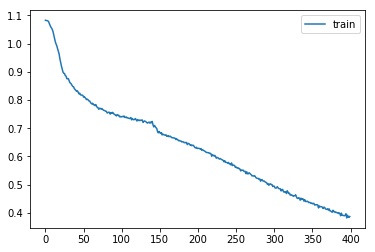

In [6]:
from matplotlib import pyplot as plt

# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [7]:
score = rnn.evaluate(
    [
        #X_test_timestamp,
        X_test_volume,
        #X_test_trends,
        X_test_lagged_price
    ],
    [
        Y_test_is_spike_onehot
    ])

print('\n')
print("Accuracy: %.2f%%" % (score[1]*100))

4416/4524 [============================>.] - ETA: 0s

Accuracy: 31.90%


### To test if Google Trends actually have any benefit in predicting spikes, I ran one with and without the trend data as input. 

#### For "Is Spike" cutoff of 0.1, (meaning Is Spike marks only the 10% biggest changes)
    * With trend data, accuracy was 78.90% on test data.
    * Without trend data, accuracy was 82.93% on test data.
    
#### For "Is Spike" cutoff of 0.3, 
    * With trend data, accuracy was 84.57% for epoch=40 and 89.69% for epoch=60, 87.98% for epoch=100, and 92.02% for epoch=200
    * Without trend data, accuracy was 78.40% for epoch=40 and 88.88% for epoch=60, 93.60% for epoch=100, and 90.14% for epoch=200
    
    
    * Accuracy on test data is much better than that of train data 
        * -> could be because the test data is statistically different than train data 
            * which makese sense because test data is the real big spike 
                    * Since I am using 10 hours of data to predict the next hour, it would make sense that the accuracy is good during this time since this is the time that people were looking up Bitcoin and perhaps buying them a few hours later 
                * get more up-to-date data 
        * OR BECAUSE TRAIN AND TEST DATA SOMEHOW OVERLAPS?
        
#### With updated data
    * With trend data, accuracy was 45.12% for epoch=100, 45.56% for epoch=200 -> overfitting?
        * -> put in dropout 
    - Without trend data, accuracy was 43.11% for epoch=100, 43.97% for epoch=200
    
    * with the updated data, the test data is now from December 20th, which is right after the massive spike already happened, to June
    * Before, test data used to be from start of October to April-ish
    
#### With Updated Data and with Dropout of 0.2 
    * With trend data, accuracy was 38.61% for epoch=150
    * Without trend data, accuracy was 38.87% for epoch=150
    
    TODO: Increase data_length (memory in LSTM) and change dropout 
    
#### Data_length=12 with Dropout of 0.2 
    * With trend data, accuracy was 38.44% for epoch=400
    * Without trend data, accuracy was 31.90% for epoch=400
    
#### Increasing data_length to 20 (with dropout)
    * With trend data, accuracy was 38.23% with epoch=150
    
#### Data_length of 20 without dropout 
    * With trend data, accuracy was 46.90% with epoch=100
    * Without trend data, accuracy was 46.13% with epoch=100
    
#### Data_length of 24 without dropout
    * With trend data, accuracy was 44.17% with epoch=200
    
#### Data_length of 35 without dropout
    * With trend data, accuracy was 46.8% with epoch=100
    * Without trend data, accuracy was 43.52% with epoch=100
    
#### Data_length of 50 without dropout 
    * With trend data, accuracy was 45.40% with epoch=100
    * Without trend data, accuracy was 45.67% with epoch=100
    
    
    
    * Todo: for the really high accuracy ones, graph which date ranges are most accurate (maybe when it was spiking it had higher accuracy) 
    *Todo: graph the test data and change colors depending on if value was predicted correctly or not!!!!!!!!!

In [29]:
yhat = rnn.predict( 
    [
        #X_test_timestamp,
        X_test_volume,
        X_test_trends,
        X_test_lagged_price
    ],
    verbose=0
)

display(yhat)

inverted_yhat = np.argmax(yhat,axis=1) #returns INDICES of max 
onehot_to_val_dict = {0: 0, 1: 1, 2:-1 }

inverted_yhat_arr = np.asarray(inverted_yhat)
predicted = [onehot_to_val_dict[i] for i in inverted_yhat_arr]


df_pred_output = pd.DataFrame(predicted, columns=['predicted'])
df_pred_output['actual'] = Y_test_is_spike
#df_pred_output['index_output'] = inverted_yhat
display(df_pred_output.head(100))

correct = (df_pred_output['actual'].values == df_pred_output['predicted'].values)
accuracy = correct.sum() / correct.size
display(accuracy)

array([[  4.52280313e-01,   3.59167723e-04,   5.47360480e-01],
       [  9.30840611e-01,   8.56013969e-03,   6.05992079e-02],
       [  9.88024890e-01,   5.18933339e-05,   1.19231120e-02],
       ..., 
       [  9.85919118e-01,   1.14388512e-02,   2.64205295e-03],
       [  9.98261154e-01,   6.32497904e-05,   1.67550833e-03],
       [  9.95321453e-01,   4.53380664e-04,   4.22520470e-03]], dtype=float32)

,predicted,actual
0,-1,-1.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


0.92023809523809519

In [31]:
# serialize model to JSON# serial 
model_json = rnn.to_json()
with open("model_classification_v1data_200epochs_10length.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
rnn.save_weights("model_classification_v1data_200epochs_10length.h5")

In [21]:
from sklearn import metrics

#print(metrics.confusion_matrix(df_pred_output['actual'].values, df_pred_output['predicted'].values,labels=[0,1,-1]))

confusion_matrix = pd.crosstab(df_pred_output['actual'].values, df_pred_output['predicted'].values, rownames=['Actual'], colnames=['Predicted'], margins=True)

display(confusion_matrix)

Predicted,-1,0,1,All
Actual,,,,
-1.0,808,298,628,1734
0.0,333,476,382,1191
1.0,500,345,760,1605
All,1641,1119,1770,4530


In [40]:
# need to check what the rnn actually learned 
# visualize predicted vs actual to get insight into this 

# try with instead of just 10% biggest changes, maybe with 25% 
# is it just learning from the previous prices, or is google trends actually helping 
# -> run rnn without google trends 


# I have a master_df_v2 now so try that - this one has 0.3 as cutoff for is Spike 
# Have to eventually get validation data - also get overall newer more data 